# HSE 2024: Mathematical Methods for Data Analysis

## Homework 3

**Warning 1**: some problems require (especially the lemmatization part) significant amount of time, so **it is better to start early (!)**

**Warning 2**: it is critical to describe and explain what you are doing and why, use markdown cells

In [3]:
from typing import Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

sns.set(style="darkgrid")

## PART 1: Logit model

We consider a binary classification problem. For prediction, we would like to use a logistic regression model. For regularization we add a combination of the $l_2$ and $l_1$ penalties (Elastic Net).

Each object in the training dataset is indexed with $i$ and described by pair: features $x_i\in\mathbb{R}^{K}$ and binary labels $y_i$. The model parametrized with bias $w_0\in\mathbb{R}$ and weights $w\in\mathbb{R}^K$. Note: Bias is included in $w$ vector

The optimization problem with respect to the $w_0, w$ is the following (Logistic loss with Elastic Net regularizers):

$$L(w, w_0) = \sum_{i=1}^{N} -y_i \log{\sigma{(w^\top x_i)}} - (1 - y_i) \log{(1 - \sigma{(w^\top x_i)})} + \gamma \|w\|_1 + \beta \|w\|_2^2$$

#### 1. [0.5 points]  Find the gradient of the Elastic Net loss and write its formulas (better in latex format). Remember what derivative sigmoid has (gradient in fact is a lot simpler than you may get using automatic tools like sympy, matlab or whatever)

$${\nabla}_wL(\mathcal{w}) = \sum_{i = 1}^N \nabla_w(-y_i \log\sigma(w^\top x_i) - (1 - y_i) \log(1 - \sigma(w^\top x_i))) + \nabla_w (\gamma \|w\|_1) + \nabla_w (\beta \|w\|_2^2) = \\
= \sum_{i = 1}^N x_i (\sigma(w^T x_i) - y_i) + \gamma sign(w) + 2\beta w = \\
= (\sigma(Xw) - y)X + \gamma sign(w) + 2\beta w$$

#### 2. [0.25 points] Implement the Elastic Net loss (as a function)

In [4]:
sigmoid = lambda x: 1.0 / (1 + np.exp(-x))

def loss(X, y, w: List[float], gamma=1., beta=1.) -> float:
    return np.dot(-y, np.log(sigmoid(X.dot(w.T)))) - np.dot(1 - y, np.log(1- sigmoid(X.dot(w.T)))) + gamma * np.linalg.norm(w, 1) + beta * np.linalg.norm(w, 2)

#### 3. [0.25 points] Implement the gradient (as a function)

In [5]:
def get_grad(X, y, w: List[float], gamma=1., beta=1.) -> Tuple[List[float], float]:
    grad_w = (sigmoid(w.dot(X.T)) - y).dot(X) + gamma * np.sign(w) + 2 * beta * w
    return grad_w

#### Check yourself

In [6]:
np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
X = np.c_[np.ones(X.shape[0]), X]
y = np.random.binomial(1, 0.42, size=10)
w = np.random.normal(size=5 + 1)

grad_w = get_grad(X, y, w)
assert(np.allclose(grad_w,
                   [-3.99447493, -1.84786723,  0.64520104,  1.67059973, -5.03858487, -5.21496336],
                   rtol=1e-2)
)

####  4. [1 point]  Implement gradient descent which works for both tol level and max_iter stop criteria and plot the decision boundary of the result

The template provides basic sklearn API class. You are free to modify it in any convenient way.

In [7]:
from sklearn.base import BaseEstimator, ClassifierMixin

In [8]:
class Logit(BaseEstimator, ClassifierMixin):
    def __init__(self, beta=1.0, gamma=1.0, lr=1e-3, tolerance=0.01,
                  max_iter=1000, random_state=42, alpha=0.5):
        self.beta = beta
        self.gamma = gamma
        self.tolerance= tolerance
        self.max_iter= max_iter
        self.learning_rate = lr
        self.random_state = random_state
        self.w = None

        self.alpha = alpha
        self.loss_history = None

        self.lr = lr  # for task 8
        self.classes_ = None  # for task 8

    def fit(self, X, y):
        # add weights and bias and optimize Elastic Net loss over (X,y) dataset
        # save history of optimization steps

        X = self._concat(X)
        self._init(size=X.shape[1])
        self.classes_ = np.unique(y)

        last_w = self.w.copy()
        current_iter = 0
        while self._stop_condition(current_iter, last_w):
            current_iter += 1
            last_w = self.w.copy()
            gradient = get_grad(X, y, self.w, gamma=self.gamma, beta=self.beta)
            self.w = self.w - self.learning_rate * gradient
            self.loss_history.append(loss(X, y, self.w, gamma=self.gamma, beta=self.beta)) 

        return self

    def predict(self, X):
        # return vector of predicted labels (0 or 1) for each object from X
        
        self._check_trained()
        
        X = self._concat(X)
        predict = np.where(sigmoid(np.dot(X, self.w.T)) < self.alpha, -1, 1)

        return predict

    def predict_proba(self, X):
      # return vector of probabilities for each object from X
        return np.array([1 / (1 + np.exp(np.dot(X, self.w))),\
                         1 / (1 + np.exp(-np.dot(X, self.w)))])
    
    def _init(self, size):
        if self.w is None:
            self.w = np.random.normal(size=size)
        if self.loss_history is None:
            self.loss_history = []

    def _check_trained(self):
        if self.w is None or self.loss_history is None:
            raise Exception("Not trained")

    def _stop_condition(self, current_iter, last_w):
        return current_iter < self.max_iter and np.linalg.norm(self.w - last_w) > self.tolerance or current_iter == 0
    
    def _concat(self, X):
        return np.c_[np.ones(X.shape[0]), X]

In [190]:
# sample data to test your model
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=180, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)

In [191]:
# a function to plot the decision boundary
def plot_decision_boundary(model, X, y):
    fig = plt.figure()
    X1min, X2min = X.min(axis=0)
    X1max, X2max = X.max(axis=0)
    x1, x2 = np.meshgrid(np.linspace(X1min, X1max, 200),
                         np.linspace(X2min, X2max, 200))
    ypred = model.predict(np.c_[x1.ravel(), x2.ravel()])
    ypred = ypred.reshape(x1.shape)

    plt.contourf(x1, x2, ypred, alpha=.4)
    plt.scatter(X[:,0], X[:,1], c=y)

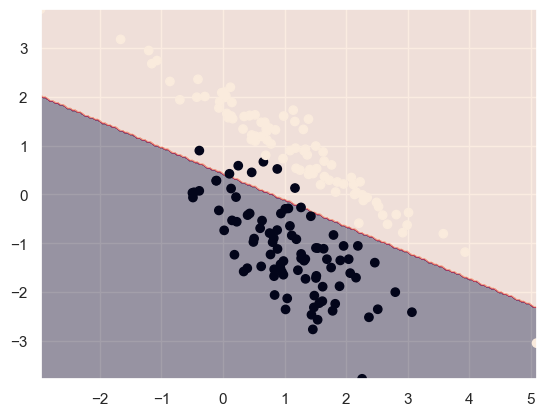

In [192]:
model = Logit(0, 0)
model.fit(X, y)
plot_decision_boundary(model, X, y)

#### 5. [0.25 points] Plot loss diagram for the model, i.e. show the dependence of the loss function from the gradient descent steps

In [193]:
def plot_loss_diagram(model):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    lh = model.loss_history
    ax.plot(range(len(lh)), lh)
    plt.xlabel("Number of iterations")
    plt.ylabel("Loss")

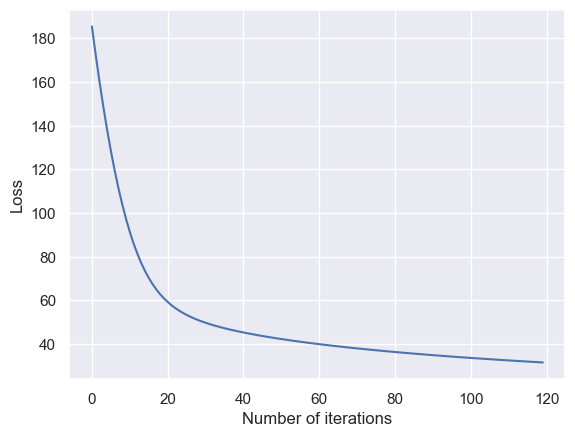

In [194]:
plot_loss_diagram(model)

## PART 2: Support Vector Machines

#### 6. [2 point] Using the same dataset, train SVM Classifier from Sklearn.
Investigate how different parameters influence the quality of the solution:
+ Try several kernels: Linear, Polynomial, RBF (and others if you wish). Some Kernels have hypermeters: don't forget to try different.
+ Regularization coefficient

Show how these parameters affect accuracy, roc_auc and f1 score.
Make plots for the dependencies between metrics and parameters.
Try to formulate conclusions from the observations. How sensitive are kernels to hyperparameters? How sensitive is a solution to the regularization? Which kernel is prone to overfitting?

In [195]:
metrics = ['accuracy', 'roc_auc', 'f1']
kernels = ['linear', 'poly', 'rbf']
reg_coefs =  [10 ** e for e in range(-4, 1)]

In [196]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import *

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [197]:
def build_result(kernels, metrics):
    return {m: {k: {'C': []} for k in kernels} for m in metrics}

In [198]:
def fill_result(result, y_test, y_pred, y_pred_proba, kernel, metrics):
    for m, y_pr, func in zip(metrics, [y_pred, y_pred, y_pred_proba[:, 1]], [accuracy_score, f1_score, roc_auc_score]):
        result[m][kernel]['C'].append(func(y_test, y_pr))

In [199]:
from itertools import product
def process(X_train, X_test, y_train, y_test, kernels, reg_coefs, metrics):
    results = build_result(kernels, metrics)
    trains = build_result(kernels, metrics)

    for k, c in product(kernels, reg_coefs):
        svc = SVC(kernel=k, C=c, probability=True, verbose=False).fit(X_train, y_train)

        y_pred = svc.predict(X_test)
        y_pred_proba = svc.predict_proba(X_test)
        fill_result(results, y_test, y_pred, y_pred_proba, k, metrics)

        y_train_pred = svc.predict(X_train)
        y_train_pred_proba = svc.predict_proba(X_train)
        fill_result(trains, y_train, y_train_pred, y_train_pred_proba, k, metrics)

    return results, trains

In [200]:
results, trains = process(X_train, X_test, y_train, y_test, kernels, reg_coefs, metrics)

In [201]:
def plot_params_affection(results, trains, kernels, reg_coefs, metrics):
    for k in kernels:
        fig, axes = plt.subplots(1, len(metrics))
        fig.set_size_inches(20, 10)
        for i, m in enumerate(metrics):
            axes[i].plot(reg_coefs, results[m][k]['C'], label=f"{k} (on test data)")
            axes[i].plot(reg_coefs, trains[m][k]['C'], label=f"{k} (on train data)")
            axes[i].set_xscale('log')
            axes[i].set_xlabel(f'C({k})')
            axes[i].set_ylabel(m)
    plt.tight_layout()
        

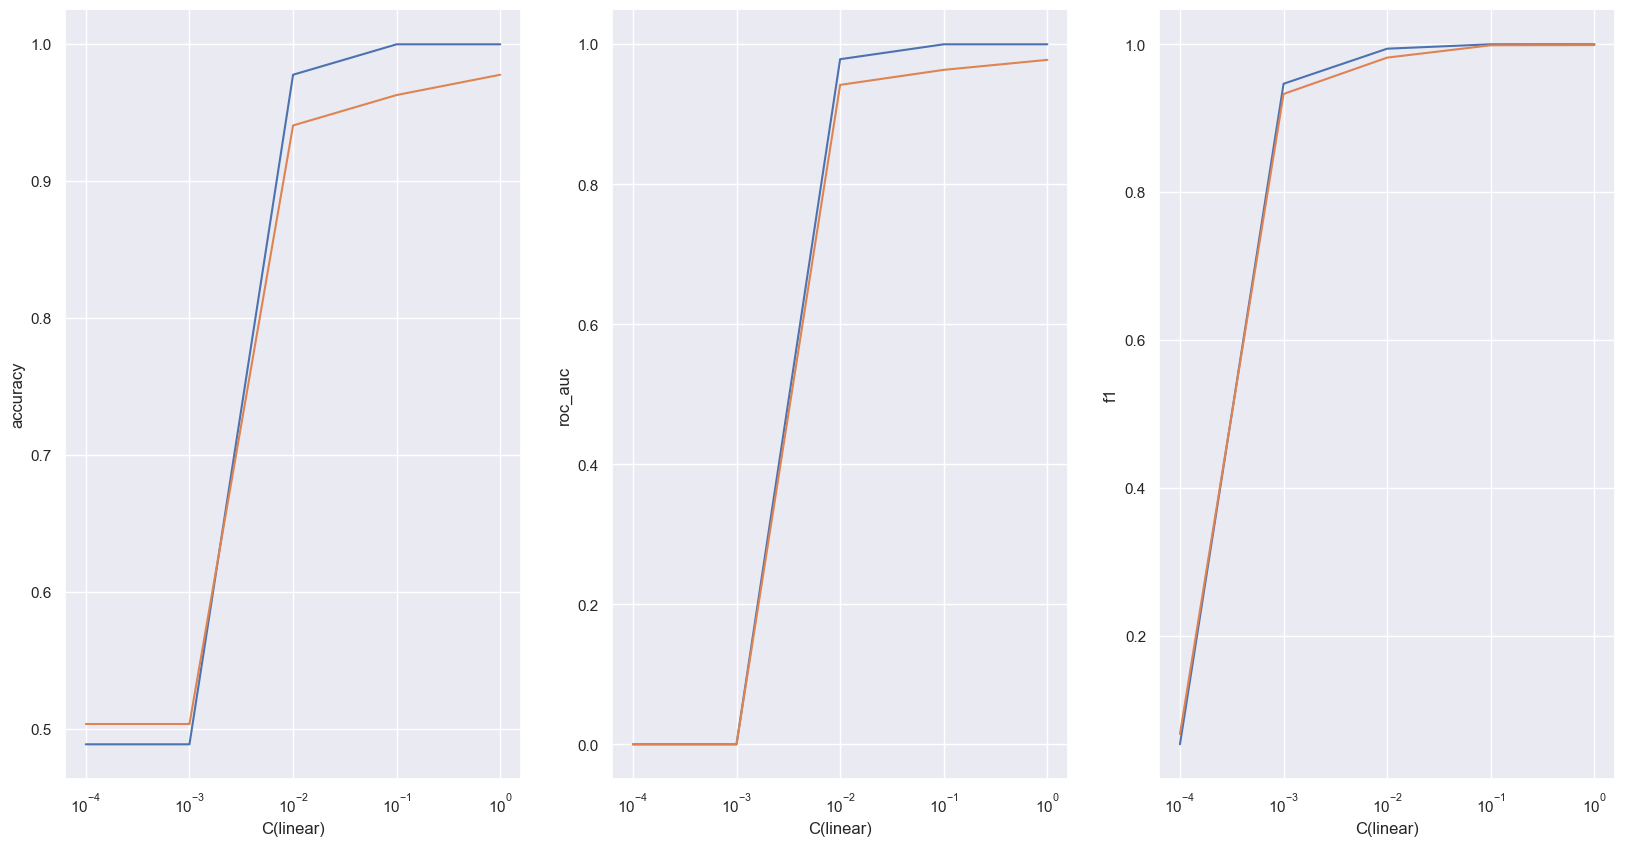

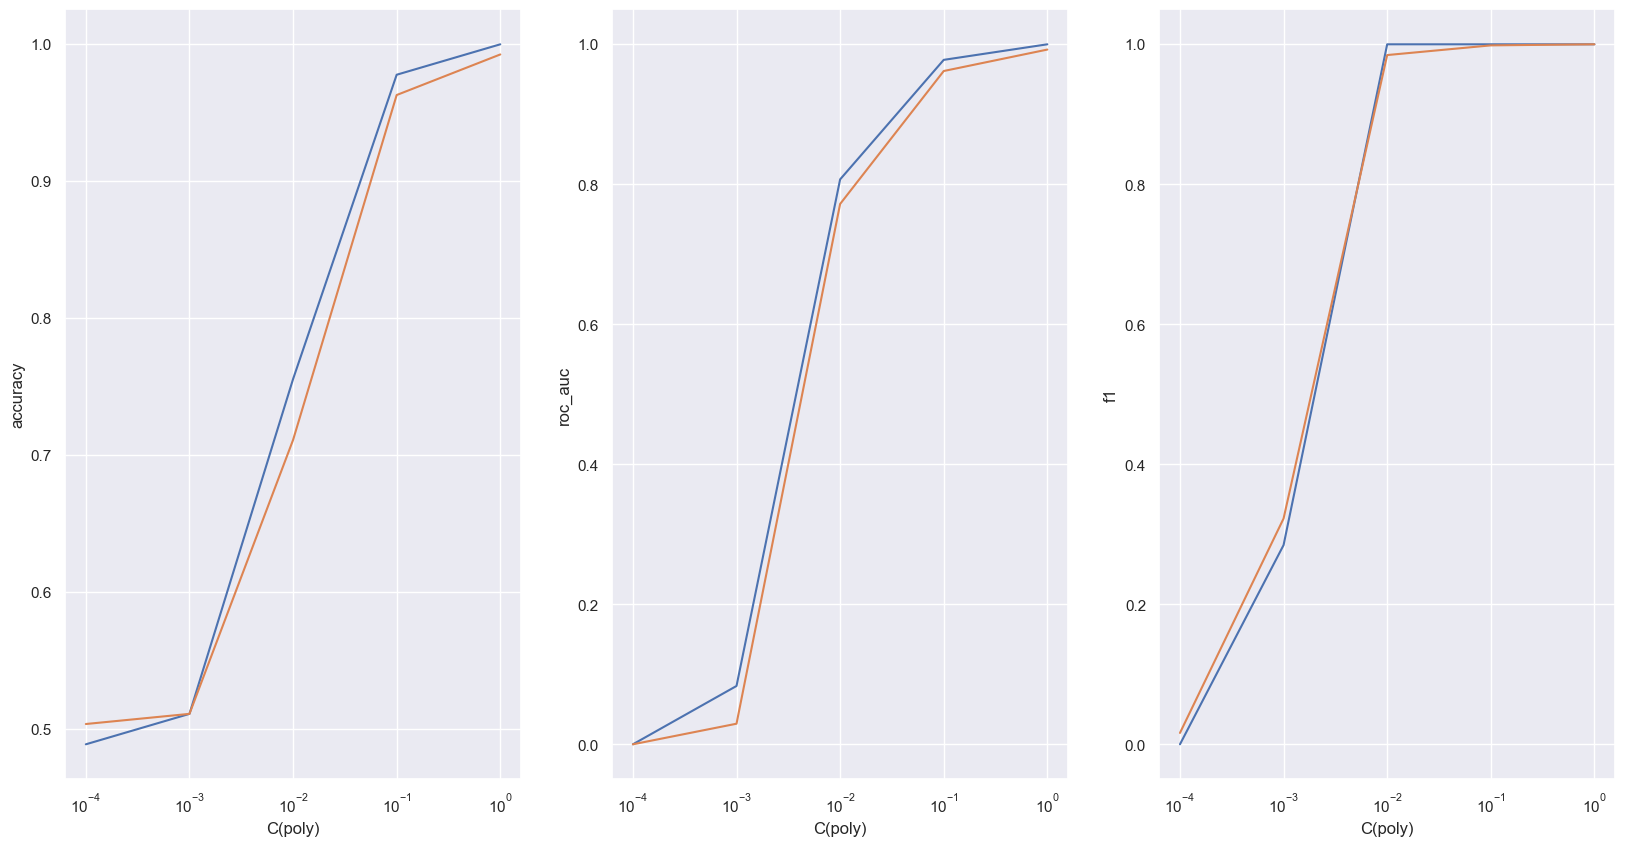

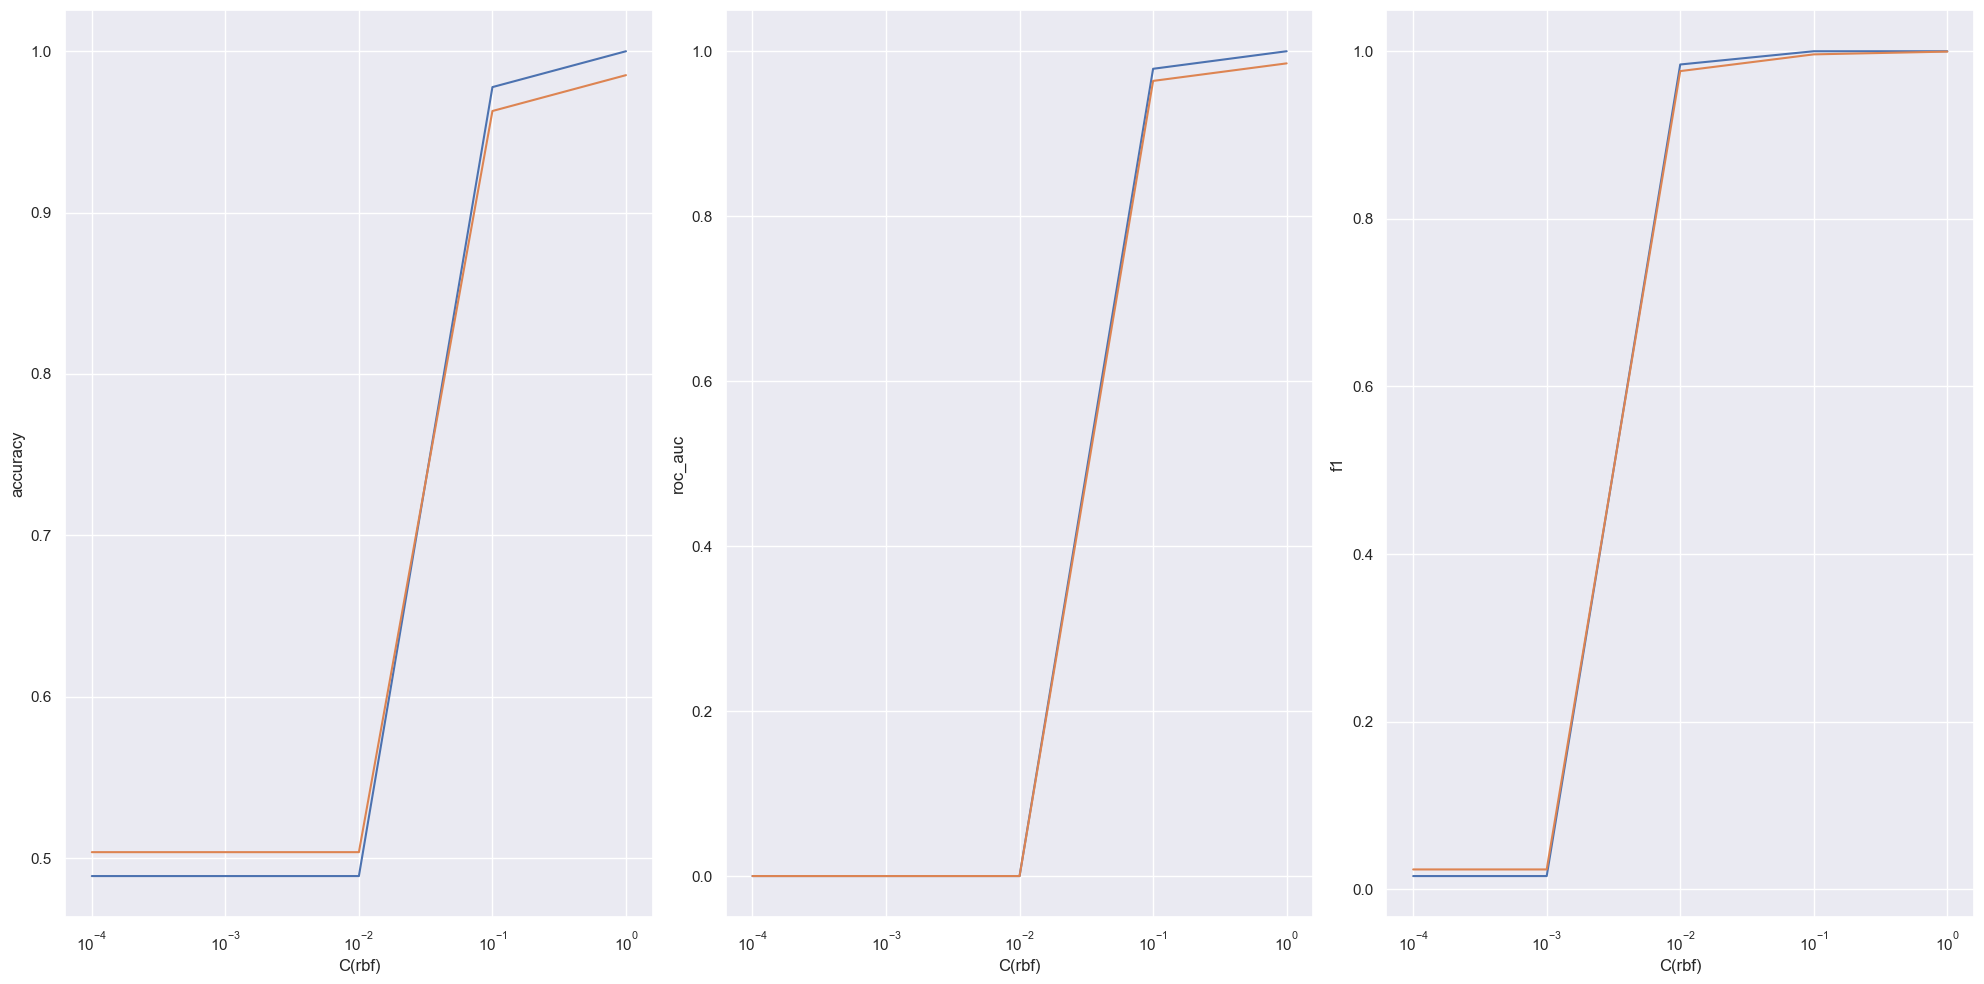

In [202]:
plot_params_affection(results, trains, kernels, reg_coefs, metrics)

##### Выводы
| Характеристика | Значение |
| -:| -:|
| Наиболее склонная к переобучению | **linear** |
| Наименее склонная к переобучению | **rbf** |
| Рост коэффициента регуляризации | улучшение качества модели |


## PART 3: Natural Language Processing

#### 7. [1.75 point] Form the dataset

We are going to form a dataset that we will use in the following tasks for binary and multiclass classification

0. Choose **six** authors that you like (specify who you've chosen) and download the <a href="https://www.kaggle.com/d0rj3228/russian-literature?select=prose">relevant data</a> from **prose** section
1. Build your own dataset for these authors:
    * divide each text into sentences such that we will have two columns: *sentence* and *target author*, each row will contain one sentence and one target
    * drop sentences where N symbols in a sentence < 15
    * fix random state and randomly choose sentences in the folowing proportion "5k : 15k : 8k : 11k : 20k : 3k" for the authors respectively
    
    sample data may look like:
    
    <center>
    <table>
        <tr>
            <th> sentence </th>
            <th> author </th>
        </tr>
        <tr><td> Несколько лет тому назад в одном из своих поместий жил старинный русской барин, Кирила Петрович Троекуров. </td><td> Пушкин </td><td>
        <tr><td> Уже более недели приезжий господин жил в городе, разъезжая по вечеринкам и обедам и таким образом проводя, как говорится, очень приятно время. </td><td> Гоголь </td><td>
        <tr><td> ... </td><td> ... </td><td>
        <tr><td> Я жил недорослем, гоняя голубей и играя в чехарду с дворовыми мальчишками. </td><td> Пушкин </td><td>         
    </table>
</center>
     
2. Preprocess (tokenize and clean) the dataset
    * tokenize, remove all stop words (nltk.corpus.stopwords), punctuation (string.punctuation) and numbers
    * convert to lower case and apply either stemming or lemmatization of the words (on your choice)
    * vectorize words using both **bag of words** and **tf-idf** (use sklearn)
    * observe and describe the difference between vectorized output (what do numbers look like after transformations and what do they represent?)

In [21]:
import os
import random

random.seed(42)

In [22]:
GLOB = "data"
MIN_SENTENCE_LENGTH = 15
COLUMNS = ('author', 'sentence')
authors = os.listdir(GLOB)
proportions = [5000, 15000, 8000, 11000, 20000, 3000]

In [19]:
def choose_by_author(authors, index, proportions):
    author = authors[index]
    sentences_by_author = []

    for book in os.listdir(f'./{GLOB}/{author}/'):
        with open(f'./{GLOB}/{author}/{book}', 'r', encoding='utf8') as f:
            for line in f:
                sentences = line.split('.')
                sentences_by_author.extend((author, sentence) for sentence in sentences if len(sentence) >= MIN_SENTENCE_LENGTH)
    
    return random.choices(sentences_by_author, k=proportions[index])

In [23]:
def read_dataset(authors, proportions):
    df = pd.DataFrame(columns=COLUMNS)

    for index in range(len(authors)):
        author_sentences = choose_by_author(authors, index, proportions)
        author_df = pd.DataFrame(author_sentences, columns=COLUMNS)
        df = pd.concat([df, author_df])
    
    return df

In [24]:
data = read_dataset(authors, proportions)
data.head(5)

,author,sentence
0,Blok,И Тристан будет в одинокой тоске носиться по ...
1,Blok,"Тогда, говорили враги, погибнет эта великая д..."
2,Blok,"Жарко невыносимо, нивы наливаются, черешни кр..."
3,Blok,Капитан стал читать ее при тусклом свете фонаря
4,Blok,Слушаешь и думаешь: где-то в тайгах и болотах...


In [16]:
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords
import string
import nltk
import pymorphy3

In [17]:
class TextProcessor:
    def __init__(self, inner_tokenizer=None, morph_analyzer=None) -> None:
        self.inner_tokenizer = WordPunctTokenizer() if inner_tokenizer is None else inner_tokenizer
        self.morph_analyzer = pymorphy3.MorphAnalyzer() if morph_analyzer is None else morph_analyzer
        self.stopwords = self._download_stopwords()

    def process(self, df: pd.DataFrame) -> pd.DataFrame:
        if any(actual != expected for (actual, expected) in zip(df.columns, ('author', 'sentence'))):
            raise Exception('Wrong format of dataframe')

        return df.copy().apply(self._process_token).apply(self._process_morph)

    def _process_morph(self, column: pd.Series):
        if column.name != 'sentence':
            return column
        return column.apply(lambda sentence: [self.morph_analyzer.parse(word)[0].normal_form for word in sentence])

    def _process_token(self, column: pd.Series):
        if column.name != 'sentence':
            return column
        return column.apply(lambda sentence: self._clear(self._tokenize(sentence.lower())))

    def _tokenize(self, text: str) -> List[str]:
        return self.inner_tokenizer.tokenize(text)
    
    def _clear(self, words: List[str]) -> List[str]:
        result = []

        for word in words:
            if word in self.stopwords:
                continue
            if word in string.punctuation:
                continue
            if word == '-':
                continue
            result.append(word)

        return result
    
    def _download_stopwords(self) -> List[str]:
        nltk.download('stopwords')
        return stopwords.words('russian')


In [25]:
text_processor = TextProcessor()
pdata = text_processor.process(data)
pdata.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Николай\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,author,sentence
0,Blok,"[тристан, одинокий, тоска, носиться, море]"
1,Blok,"[говорить, враг, погибнуть, этот, великий, душ..."
2,Blok,"[жарко, невыносимый, нива, наливаться, черешня..."
3,Blok,"[капитан, стать, читать, тусклый, свет, фонарь]"
4,Blok,"[слушать, думать, тайга, болото, жить, настоящ..."


In [211]:
def vectorize(df: pd.DataFrame, vectorizer_class, max_features=100):
    assert 'sentence' in df.columns

    text = df['sentence'].map(' '.join)
    vectorizer = vectorizer_class(max_features=max_features)
    vectorizer.fit(text)
    return vectorizer.transform(text).todense()[:5]

In [30]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [213]:
print("Vectorize using Bag of words:", vectorize(pdata, CountVectorizer), sep='\n')

Vectorize using Bag of words:
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
  0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [214]:
print("Vectorize using Tf-idf:", vectorize(pdata, TfidfVectorizer), sep='\n')

Vectorize using Tf-idf:
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0. 

##### Выводы
| Способ векторизации | Какие значения | Почему |
| -:| -:| -:|
| **Bag of words** | Целые числа | Считает количество вхождений слова |
| **Tf-idf** | Дробные числа | Считает частоту употребления слова |

###  Binary classification

#### 8. [2 point] Train model using Logistic Regression (your own) and SVC (SVM can be taken from sklearn)

* choose *two* authors from the dataset that you have formed in the previous task
* check the balance of the classes
* divide the data into train and test samples with 0.7 split rate (don't forget to fix the random state)
* using GridSearchCV - find the best parameters for the models (by F1 score) and use it in the next tasks
* make several plots to address the dependence between F1 score and parameters
* plot confusion matrix for train and test samples
* compute some relevant metrics for test sample (useful to check the seminars 5 and 6, use sklearn)
* make conclusions about the performance of your models

In [26]:
chosen_authors = ['Blok', 'Bryusov']
pdata[(pdata['author'] == chosen_authors[0]) | (pdata['author'] == chosen_authors[1])]['author'].value_counts()

author
Bryusov    15000
Blok        5000
Name: count, dtype: int64

In [27]:
raw = np.isin(pdata['author'], chosen_authors)

X = pdata['sentence'].apply(' '.join)[raw].to_numpy()
y = pdata['author'][raw].replace({"Bryusov": 1, "Blok": -1}).to_numpy()

C:\Users\Николай\AppData\Local\Temp\ipykernel_50480\4102857206.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = pdata['author'][raw].replace({"Bryusov": 1, "Blok": -1}).to_numpy()


In [28]:
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [31]:
transformer = Pipeline([
    ('tf_idf', TfidfVectorizer()),
    ('truncated_svd', TruncatedSVD(random_state=42)),
    ('std_scaler', StandardScaler())
]) 

assert X.shape == y.shape
X = transformer.fit_transform(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

In [10]:
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [32]:
logit = Logit(0, 0).fit(X_train, y_train)

y_train_pred_logit = logit.predict(X_train)
y_test_pred_logit = logit.predict(X_test)

In [221]:
params = {
    'beta': [10 ** e for e in range(-4, 1)],
    'gamma': [10 ** e for e in range(-4, 1)],
    'lr': [10 ** (3 * e) for e in range(-3, 0)],
    'tolerance': [10 ** (2 * e) for e in range(-4, 0)],
    'max_iter': [100],
}

gscv = GridSearchCV(logit, params, scoring='f1_micro')

In [222]:
gscv.fit(X_train, y_train)

C:\Users\Николай\AppData\Local\Temp\ipykernel_36784\3396868489.py:4: RuntimeWarning: divide by zero encountered in log
  return np.dot(-y, np.log(sigmoid(X.dot(w.T)))) - np.dot(1 - y, np.log(1- sigmoid(X.dot(w.T)))) + gamma * np.linalg.norm(w, 1) + beta * np.linalg.norm(w, 2)


GridSearchCV(estimator=Logit(beta=0, gamma=0),
             param_grid={'beta': [0.0001, 0.001, 0.01, 0.1, 1],
                         'gamma': [0.0001, 0.001, 0.01, 0.1, 1],
                         'lr': [1e-09, 1e-06, 0.001], 'max_iter': [100],
                         'tolerance': [1e-08, 1e-06, 0.0001, 0.01]},
             scoring='f1_micro')

Оно крутилось 23 минуты 40.5 секунд (((( \
Можно устаноновить `max_iter`, но тогда просядет точность

(когда перезапускал, всё-таки добавил параметр, чтобы сэкономить время, дальше создаю с захардкоженными лучшими парметрами)

In [223]:
gscv.best_params_

{'beta': 0.0001,
 'gamma': 0.001,
 'lr': 1e-06,
 'max_iter': 100,
 'tolerance': 0.0001}

In [224]:
def get_best_params(results, count=None):
    assert count is None or count > 0
    params = results['params']
    mts = results['mean_test_score']
    zipka = list(sorted(zip(params, mts), key=lambda pair: pair[1], reverse=True))
    return zipka if count is None else zipka[:count]

In [225]:
best = get_best_params(gscv.cv_results_)

In [226]:
def plot_params_scores(params_and_mts: List[Tuple[dict, float]]):

    n = len(params_and_mts)
    number_of_params = len(params_and_mts[0][0])
    
    fig, axes = plt.subplots(number_of_params, 1, figsize=(20, 20))

    for ax, param in zip(axes, params_and_mts[0][0]):
        sorted_pairs = list(sorted(params_and_mts, key=lambda pair: pair[0][param]))
        x = [val[0][param] for val in sorted_pairs]
        y = [val[1] for val in sorted_pairs]
        ax.set_xlabel(param)
        ax.set_ylabel('score')
        ax.plot(x, y)
    
    plt.show()       

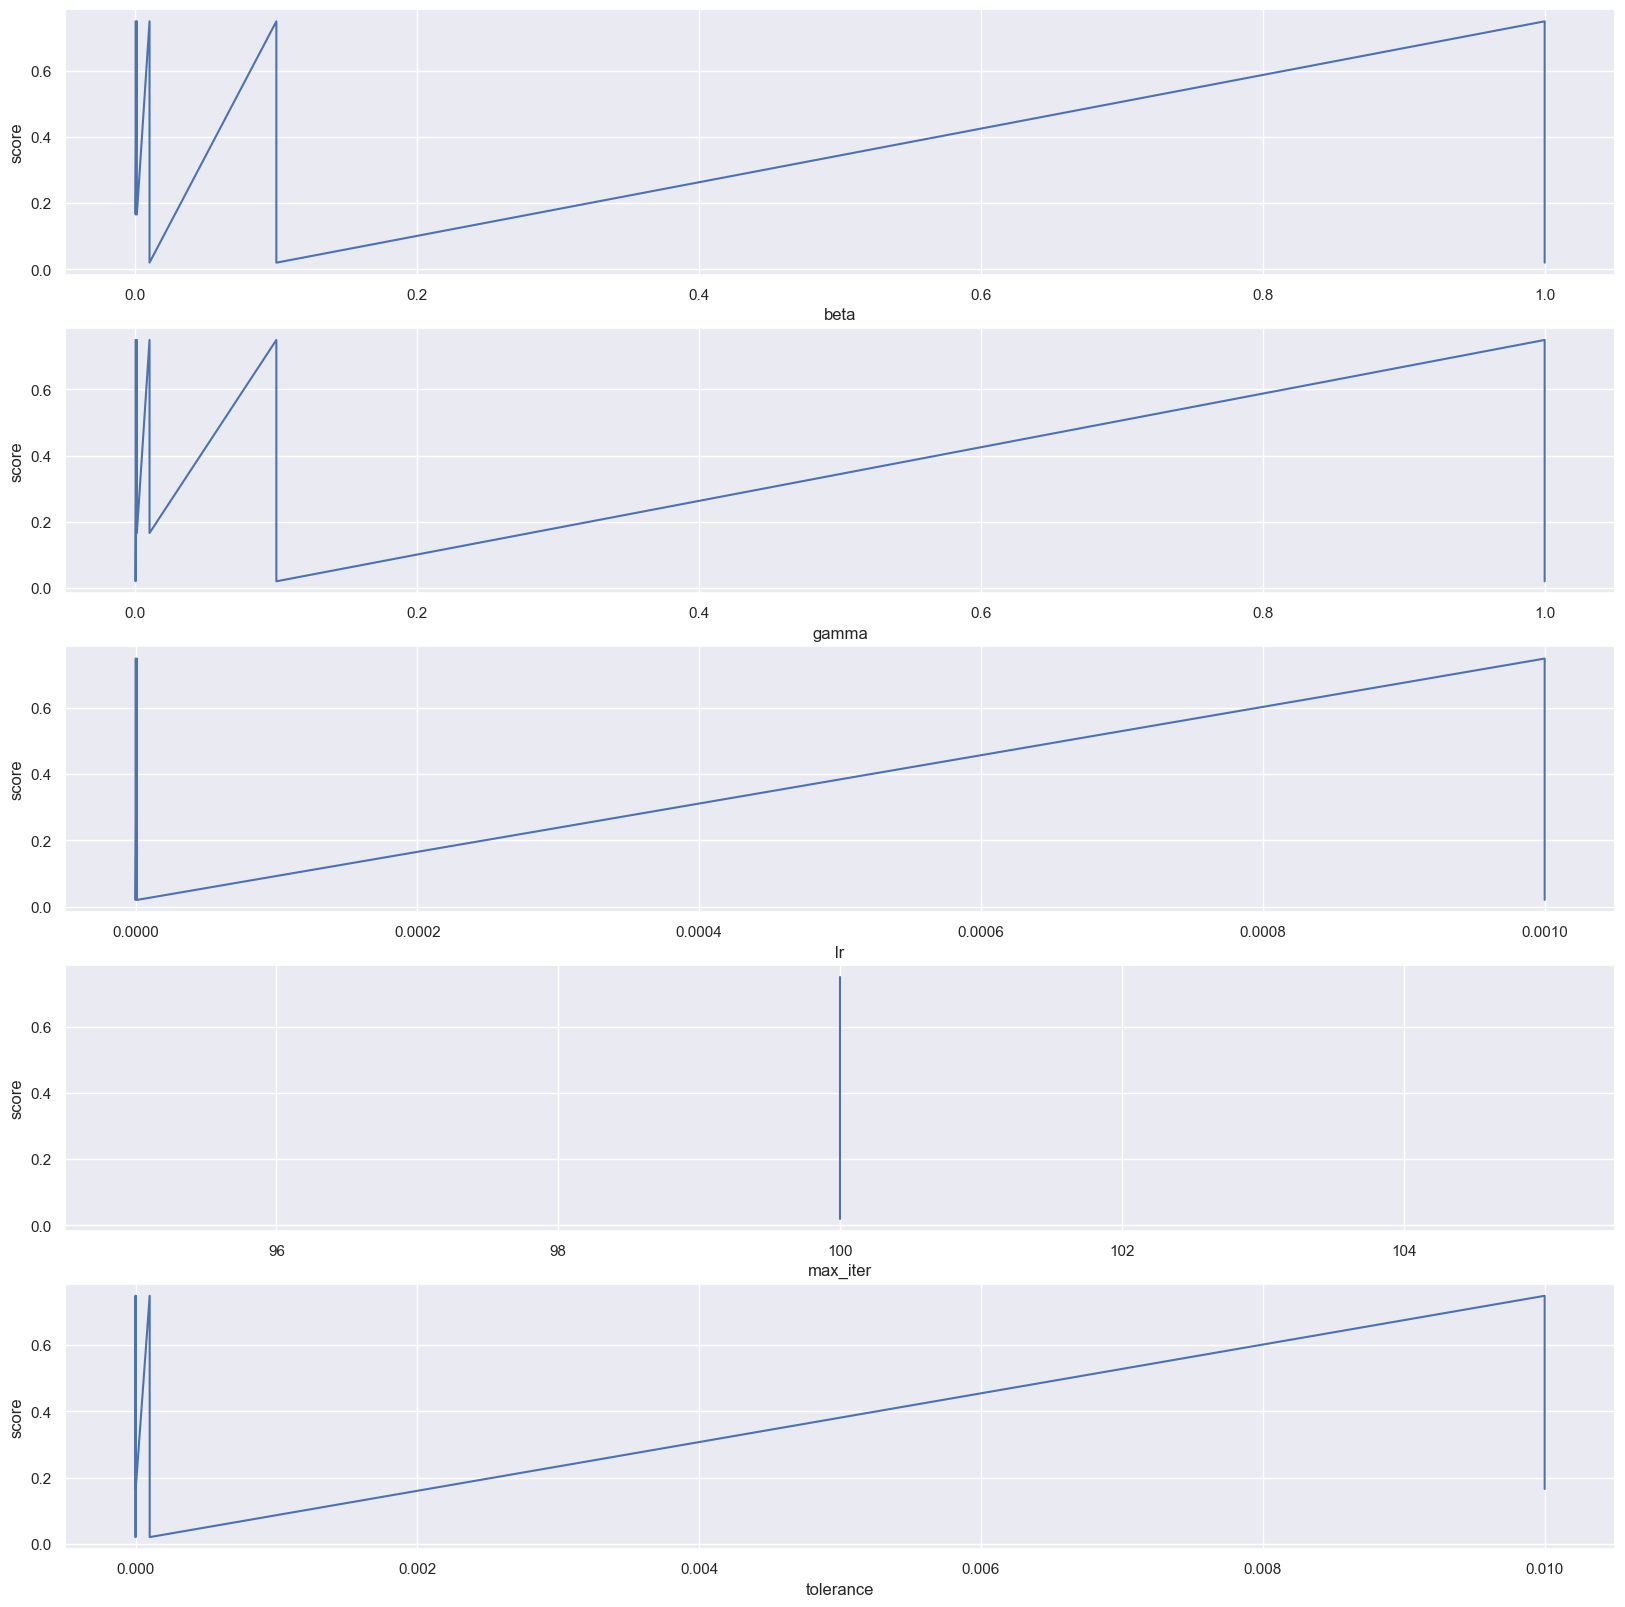

In [227]:
plot_params_scores(best)

##### Выводы
Если смотреть только на один параметр, сложно сказать, как именно он влияет на оценку, из чего можно сделать вывод, что на улучшение оценки влияет не какой-то один параметр, а их совокупность

In [11]:
logit, svc = (Logit(beta=0.0001, gamma=0.01, lr=1e-06, tolerance=0.01), SVC(C=10, gamma='scale'))

In [33]:
logit.fit(X_train, y_train)

Logit(beta=0, gamma=0)

In [37]:
svc.fit(X_train, y_train)

SVC(C=10)

In [34]:
y_train_pred_logit = logit.predict(X_train)

In [35]:
y_test_pred_logit = logit.predict(X_test)

In [38]:
y_train_pred_svc = svc.predict(X_train)

In [39]:
y_test_pred_svc = svc.predict(X_test)

In [47]:
real_pred_titles = [
    (y_train, y_train_pred_logit, 'Logit, on train data'),
    (y_test, y_test_pred_logit, 'Logit, on test data'),
    (y_train, y_train_pred_svc, 'SVC, on train data'),
    (y_test, y_test_pred_svc, 'SVC, on test data'),
]

In [50]:
def print_confusion_matrix(real_pred_titles):
    for real, pred, title in real_pred_titles:
        print(title, confusion_matrix(real, pred, labels=[1, -1]), sep='\n')
        print()

In [51]:
print_confusion_matrix(real_pred_titles)

Logit, on train data
[[  278 10207]
 [   43  3472]]

Logit, on test data
[[ 117 4398]
 [  18 1467]]

SVC, on train data
[[10449    36]
 [ 3371   144]]

SVC, on test data
[[4500   15]
 [1425   60]]



In [45]:
chosen_authors_sorted = ["Bryusov", "Blok"]

def plot_confusion_matrix(real_pred_titles):
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))

    for ax, (real, pred, title) in zip(np.ravel(axes), real_pred_titles):
        sns.heatmap(ax=ax, data=confusion_matrix(real, pred, labels=[1, -1]), annot=True, fmt='d', cbar=False,
                    xticklabels=chosen_authors_sorted, yticklabels=chosen_authors_sorted)
        ax.set_title(title)
    
    plt.show()

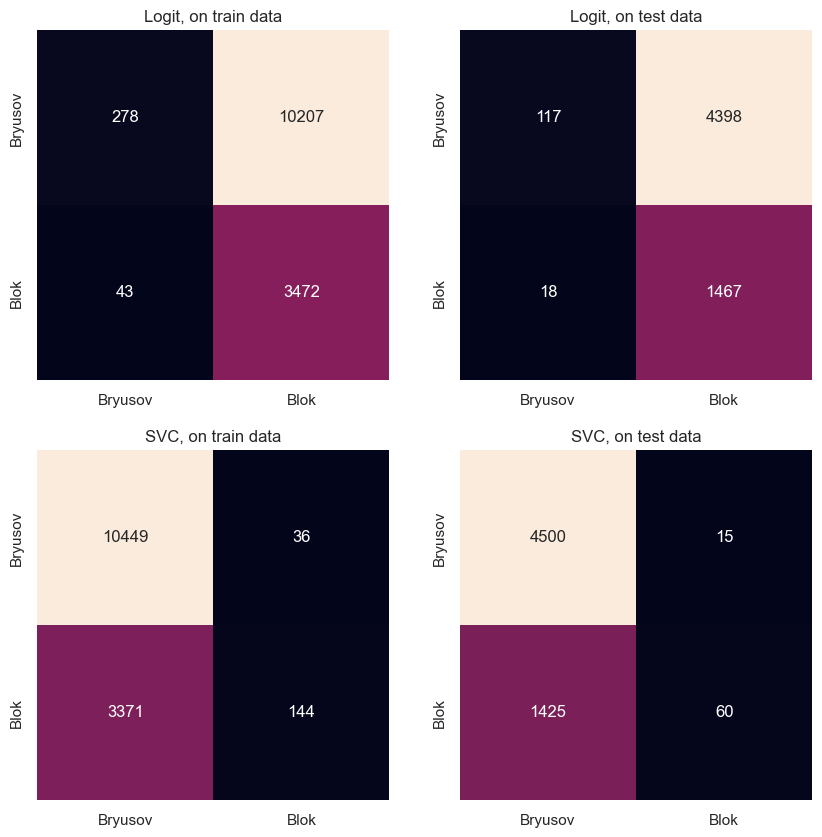

In [46]:
plot_confusion_matrix(real_pred_titles)

In [241]:
logit = Logit(0, 0).fit(X_train, y_train)

In [242]:
svc = SVC(C=1000, gamma='scale').fit(X_train, y_train)

In [243]:
ts_logit = logit.predict(X_test)

In [244]:
ts_svc = svc.predict(X_test)

In [99]:
def print_metrics(title, test, pred):
    funcs = (precision_score, recall_score, f1_score)
    titles = ("Precision", "Recall", "F1")

    print(title)
    for title, func in zip(titles, funcs):
        print(title + ": " + str(func(test, pred, average='macro')))
    print("Accuracy:", accuracy_score(test, pred))

In [246]:
print_metrics("~~~ Logit ~~~", y_test, ts_logit)

~~~ Logit ~~~
Precision: 0.2888888888888889
Recall: 0.008637873754152824
F1: 0.016774193548387096
Accuracy: 0.0195


c:\Users\Николай\папки\вышка отрыжка\mmad\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Николай\папки\вышка отрыжка\mmad\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [247]:
print_metrics("~~~ SVC ~~~", y_test, ts_svc)

~~~ SVC ~~~
Precision: 0.7589755754569563
Recall: 0.5363110618924573
F1: 0.5057116590321102
Accuracy: 0.766


#### 9. [1 point] Analysing ROC AUC

It is possible to control the proportion of statistical errors of different types using different thresholds for choosing a class. Plot ROC curves for Logistic Regression and SVC, show the threshold on ROC curve plots. Choose such a threshold that your models have no more than 30% of false positive errors rate. Pay attention to `thresholds` parameter in sklearn roc_curve

In [248]:
data = read_dataset(authors, proportions)

In [249]:
processed_data = text_processor.process(data)

In [250]:
raw = np.isin(processed_data['author'], chosen_authors)

X = processed_data['sentence'].apply(' '.join)[raw].to_numpy()
y = processed_data['author'][raw].replace({"Bryusov": 1, "Blok": -1}).to_numpy()

C:\Users\Николай\AppData\Local\Temp\ipykernel_36784\3435869460.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = processed_data['author'][raw].replace({"Bryusov": 1, "Blok": -1}).to_numpy()


In [251]:
transformer = Pipeline([
    ('tf_idf', TfidfVectorizer()),
    ('truncated_svd', TruncatedSVD(random_state=42)),
    ('std_scaler', StandardScaler())
]) 

assert X.shape == y.shape
X = transformer.fit_transform(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

In [252]:
print(X_train.shape)

(14000, 2)


In [253]:
def plot_roc_curve(model, X_test, y_test):
    fpr_svc, tpr_svc, thresholds_svc = roc_curve(y_test, np.array(svc.predict(X_test)))
    roc_auc_svc = auc(fpr_svc, tpr_svc)
    display_svc = RocCurveDisplay(fpr=fpr_svc, tpr=tpr_svc, roc_auc=roc_auc_svc)
    display_svc.plot()

In [254]:
svc = SVC(C=1000).fit(X, y)

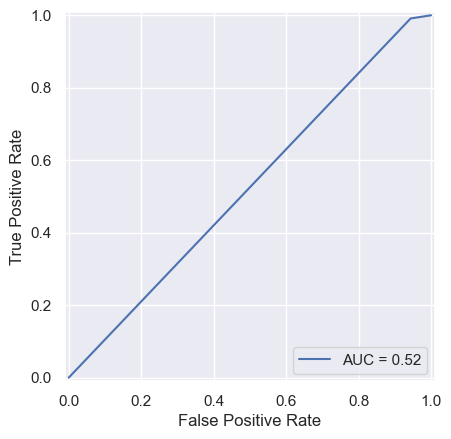

In [255]:
plot_roc_curve(svc, X_test, y_test)

In [256]:
logit = Logit(beta=0.0001, gamma=0.01, lr=1e-06, tolerance=0.01).fit(X, y)

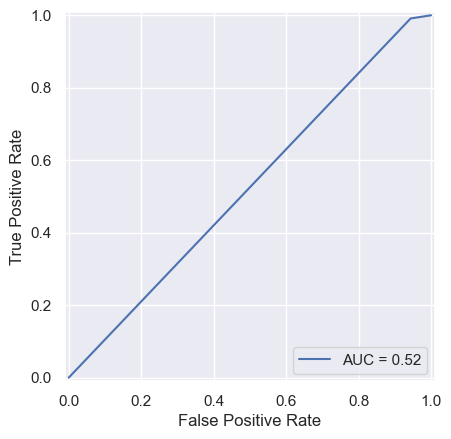

In [257]:
plot_roc_curve(logit, X_test, y_test)

### Multiclass logit

#### 10. [1 point] Take the One-VS-One classifier (use sklearn) and apply to Logit model (one you've made in the 4th task) in order to get multiclass linear classifier

*It is possible to use sklearn model instead of your own one but with a penalty of 0.5*

<a href="https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsOneClassifier.html">OneVsOneClassifier</a>

* use the data you got at the previous step for 6 authors
* divide the data into train and test samples with 0.7 split rate
* using GridSearchCV - find the best parameters for the models (by F1 score)
* plot confusion matrix for train and test samples
* compute relevant metrics for test sample (use sklearn)

In [52]:
data = read_dataset(authors, proportions)

In [53]:
processed_data = text_processor.process(data)

In [71]:
processed_data['sentence'] = processed_data['sentence'].apply(' '.join)

In [72]:
X_train, X_test, y_train, y_test = train_test_split(processed_data['sentence'], processed_data['author'],
                                                    train_size=0.7, random_state=42)

In [73]:
vectorizer = TfidfVectorizer(max_features = 1000)
vectorizer.fit(processed_data["sentence"].tolist())
X_train_vec = vectorizer.transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [74]:
mapping = {
    x: authors.index(x) 
    for x in authors
}

y_train = y_train.apply(lambda x: mapping[x])
y_test = y_test.apply(lambda x: mapping[x])

In [265]:
from sklearn.multiclass import OneVsOneClassifier
from sklearn.linear_model import LogisticRegression

params = {
    'estimator__C': [10 ** e for e in range(-3, 1)],
}

ovoc = OneVsOneClassifier(LogisticRegression(verbose=False), n_jobs=-1)
gscv = GridSearchCV(ovoc, params, scoring='f1_micro')

In [266]:
gscv.fit(X_train_vec, y_train)

GridSearchCV(estimator=OneVsOneClassifier(estimator=LogisticRegression(verbose=False),
                                          n_jobs=-1),
             param_grid={'estimator__C': [0.001, 0.01, 0.1, 1]},
             scoring='f1_micro')

In [267]:
pred = gscv.predict(X_test_vec)
pred_train = gscv.predict(X_train_vec)

In [268]:
print_metrics("OneVsOneClassifier", y_test, pred)

OneVsOneClassifier
Precision: 0.521559951441481
Recall: 0.43088646658898827
F1: 0.43973444935488465
Accuracy: 0.5331182795698924


In [101]:
def plot_heatmap(title, test, pred):
    sns.heatmap(data=confusion_matrix(test, pred), annot=True, fmt="d",
            cbar=False, xticklabels=authors, yticklabels=authors)
    plt.title(title)
    plt.show()

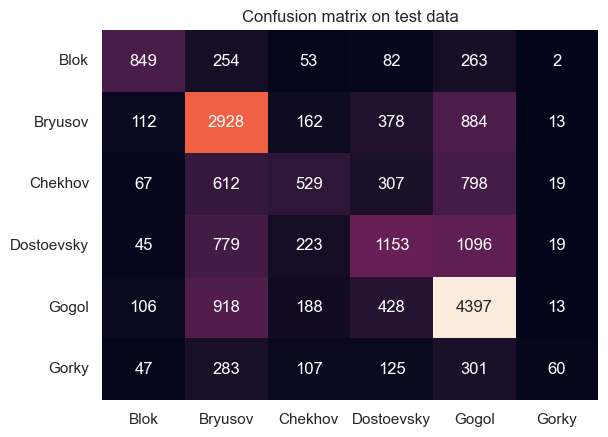

In [270]:
plot_heatmap("Confusion matrix on test data", y_test, pred)

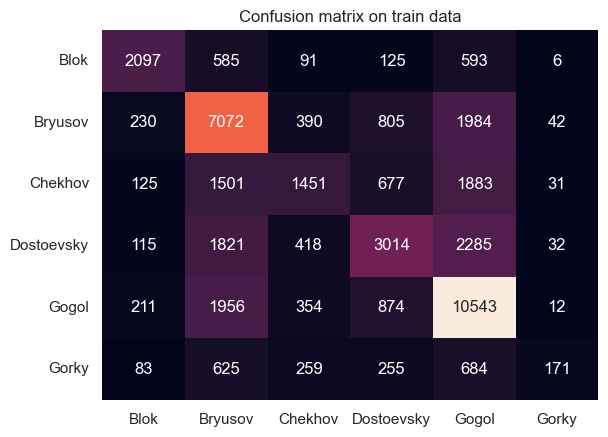

In [271]:
plot_heatmap("Confusion matrix on train data", y_train, pred_train)

##### А можно за это всё-таки полный балл? Всё-таки со своим классом классификатором работает:)

In [90]:
class Random(BaseEstimator, ClassifierMixin):
    def __init__(self):
        self.unique_values = []

    def fit(self, X, y):
        self.unique_values = np.unique_values(y)
        return self
    
    def predict(self, X):
        return np.random.choice(self.unique_values, X.shape[0])
    
    def predict_proba(self, X):
        return np.random.normal(0, 1, X.shape).reshape(X.shape)


In [85]:
svc = SVC(probability=True)

In [86]:
svc.fit(X, y)

SVC(probability=True)

In [92]:
rnd = Random().fit(X, y)

In [66]:
rnd_prdct = rnd.predict(X_test)

In [93]:
prob = rnd.predict_proba(X_test)

In [96]:
from sklearn.multiclass import OneVsOneClassifier

params = {}

ovoc = OneVsOneClassifier(Random(), n_jobs=-1)
gscv = GridSearchCV(ovoc, params, scoring='f1_macro')

In [97]:
gscv.fit(X_train_vec, y_train)

GridSearchCV(estimator=OneVsOneClassifier(estimator=Random(), n_jobs=-1),
             param_grid={}, scoring='f1_macro')

In [98]:
pred = gscv.predict(X_test_vec)
pred_train = gscv.predict(X_train_vec)

In [100]:
print_metrics("OneVsOneClassifier", y_test, pred)

OneVsOneClassifier
Precision: 0.16490154318868047
Recall: 0.1634932360150573
F1: 0.15086411159315757
Accuracy: 0.16451612903225807


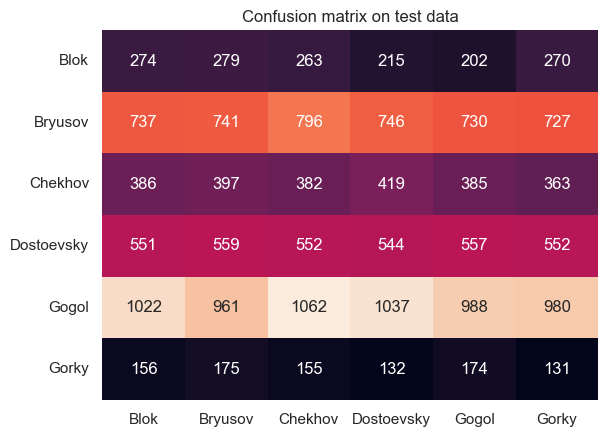

In [102]:
plot_heatmap("Confusion matrix on test data", y_test, pred)

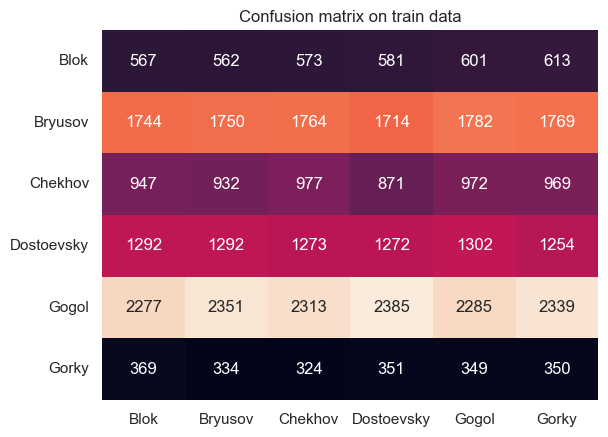

In [103]:
plot_heatmap("Confusion matrix on train data", y_train, pred_train)